In [96]:
!pip install kornia

In [97]:
from transformers import AutoModelForImageSegmentation
birefnet = AutoModelForImageSegmentation.from_pretrained('ZhengPeng7/BiRefNet', trust_remote_code=True)

In [98]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
from google.colab import drive
import torch.nn.functional as F
import matplotlib.pyplot as plt
import wandb
# from models.birefnet import BiRefNet

In [99]:
wandb.init(project='segmentation_birefnet_8testpic', config={'epochs': 35, 'batch_size': 2,'learning_rate': 1e-4})

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: kalinicheva2007 (pdftotex) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


In [100]:
# один раз перед работой, если есть новые маски

'''drive.mount('/content/drive')
masks_dir = '/content/drive/MyDrive/Курсовая/masks'
threshold = 20

for filename in os.listdir(masks_dir):
    if filename.endswith('.png'):
        file_path = os.path.join(masks_dir, filename)
        img = Image.open(file_path)
        gray = img.convert('L')  # градации серого
        arr = np.array(gray)
        bin_arr = np.where(arr > threshold, 255, 0).astype(np.uint8)  # если больше 20, то 255, иначе 0
        bin_mask = Image.fromarray(bin_arr)
        bin_mask.save(file_path)
        print(f'Processed {filename}')'''

"drive.mount('/content/drive')\nmasks_dir = '/content/drive/MyDrive/Курсовая/masks'\nthreshold = 20\n\nfor filename in os.listdir(masks_dir):\n    if filename.endswith('.png'):\n        file_path = os.path.join(masks_dir, filename)\n        img = Image.open(file_path)\n        gray = img.convert('L')  # градации серого\n        arr = np.array(gray)\n        bin_arr = np.where(arr > threshold, 255, 0).astype(np.uint8)  # если больше 20, то 255, иначе 0\n        bin_mask = Image.fromarray(bin_arr)\n        bin_mask.save(file_path)\n        print(f'Processed {filename}')"

In [101]:
birefnet.train()

BiRefNet(
  (bb): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0): BasicLayer(
        (blocks): ModuleList(
          (0): SwinTransformerBlock(
            (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=192, out_features=576, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=192, out_features=192, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path): Identity()
            (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
            (mlp): Mlp(
              (fc1): Linear(in_features=192, out_features=768, bias=T

In [102]:
class CustomDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.image_files = sorted(f for f in os.listdir(image_dir) if f.endswith('.jpg'))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        mask_name = os.path.splitext(img_name)[0] + '.png'  # имя маски совпадает с именем изображения, разница в расширении
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, mask_name)
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')

        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        #print("Mask range:", mask.min().item(), mask.max().item())

        return image, mask

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

mask_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

drive.mount('/content/drive')
mask_dir = '/content/drive/MyDrive/Курсовая/masks'
image_dir = '/content/drive/MyDrive/Курсовая/images'
# image_dir = '/content/images'
# mask_dir = '/content/masks'
dataset = CustomDataset(image_dir=image_dir, mask_dir=mask_dir, image_transform=transform, mask_transform=mask_transform)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)  # batch 2 для теста

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [103]:
# для бинарной сегментации
# targets 0 или 1
# smooth чтобы на 0 не делить
def dice_loss(inputs, targets, smooth=1e-6):
    inputs = torch.sigmoid(inputs)  # преобразование логитов к [0, 1]
    inputs = inputs.view(-1)  # векторизуем
    targets = targets.view(-1)

    intersection = (inputs * targets).sum()
    dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
    return 1 - dice

# только dice loss не справлялся на нормальном уровне. по числам было ок, по картинкам ужас
class BCEDiceLoss(nn.Module):
    def __init__(self, weight=None, smooth=1e-6):
        super(BCEDiceLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss(weight=weight)
        self.smooth = smooth

    def forward(self, inputs, targets):
        bce_loss = self.bce(inputs, targets)
        d_loss = dice_loss(inputs, targets, smooth=self.smooth)
        return bce_loss + d_loss

In [104]:
# criterion = nn.BCEWithLogitsLoss()
criterion = BCEDiceLoss()
optimizer = optim.Adam(birefnet.parameters(), lr=0.001)

In [105]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
birefnet.to(device)

BiRefNet(
  (bb): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0): BasicLayer(
        (blocks): ModuleList(
          (0): SwinTransformerBlock(
            (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=192, out_features=576, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=192, out_features=192, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path): Identity()
            (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
            (mlp): Mlp(
              (fc1): Linear(in_features=192, out_features=768, bias=T

In [106]:
def extract_first_tensor(x):
    if isinstance(x, torch.Tensor):
        return x
    elif isinstance(x, (list, tuple)):
        for item in x:
            res = extract_first_tensor(item)
            if res is not None:
                return res
    return None

In [107]:
def pixel_accuracy(pred, target):
    correct = (pred == target).float().sum()
    total = torch.numel(pred)
    return correct / total

def iou_score(pred, target):
    pred = pred.long()
    target = target.long()
    intersection = (pred & target).float().sum(dim=(1,2,3))  # sum по C, H и W
    union = (pred | target).float().sum(dim=(1,2,3))
    iou = (intersection / (union + 1e-7)).mean()
    return iou

def dice_score(pred, target):
    pred = pred.float()
    target = target.float()
    intersection = (pred * target).sum(dim=(1,2,3))
    dice = (2.0 * intersection) / (pred.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3)) + 1e-7)
    return dice.mean()

In [108]:
# num_epochs = 20
wandb.watch(birefnet, log='all')
num_epochs = wandb.config.epochs

for epoch in range(num_epochs):
    birefnet.train()
    running_loss = 0.0
    running_acc = 0.0
    running_iou = 0.0
    running_dice = 0.0
    num_batches = 0

    for images, masks in dataloader:
        optimizer.zero_grad()
        if isinstance(masks, list):
            masks = torch.stack(masks, dim=0)
        masks = masks.to(device)
        images = images.to(device)
        outputs = birefnet(images)
        outputs_tensor = extract_first_tensor(outputs)
        if outputs_tensor is None:
            raise ValueError('Не удалось извлечь тензор из outputs')
        outputs_tensor = F.interpolate(outputs_tensor, size=masks.shape[-2:], mode='bilinear', align_corners=False)
        loss = criterion(outputs_tensor, masks)
        # loss = dice_loss(outputs_tensor, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        preds = torch.sigmoid(outputs_tensor)
        preds = (preds > 0.5).float()

        acc = pixel_accuracy(preds, masks)
        running_acc += acc.item()
        iou_val = iou_score(preds, masks)
        running_iou += iou_val.item()
        dice_val = dice_score(preds, masks)
        running_dice += dice_val.item()
        num_batches += 1

    # print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(dataloader):.4f}')
    epoch_loss = running_loss / num_batches
    epoch_acc = running_acc / num_batches
    # print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Pixel Accuracy: {epoch_acc:.4f}')
    epoch_iou  = running_iou  / num_batches
    epoch_dice = running_dice / num_batches

    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Loss: {epoch_loss:.4f}, '
          f'Pixel Acc: {epoch_acc:.4f}, '
          f'IoU: {epoch_iou:.4f}, '
          f'Dice: {epoch_dice:.4f}')

    wandb.log({'epoch': epoch + 1,
               'loss': epoch_loss,
               'pixel_accuracy': epoch_acc,
               'iou': epoch_iou,
               'dice': epoch_dice})

Epoch [1/35], Loss: 1.3201, Pixel Acc: 0.5012, IoU: 0.2335, Dice: 0.3689
Epoch [2/35], Loss: 1.2935, Pixel Acc: 0.7142, IoU: 0.4400, Dice: 0.6136
Epoch [3/35], Loss: 1.2643, Pixel Acc: 0.6795, IoU: 0.3965, Dice: 0.5601
Epoch [4/35], Loss: 1.2425, Pixel Acc: 0.7398, IoU: 0.4461, Dice: 0.5892
Epoch [5/35], Loss: 1.2288, Pixel Acc: 0.7392, IoU: 0.4716, Dice: 0.6455
Epoch [6/35], Loss: 1.2121, Pixel Acc: 0.7635, IoU: 0.5177, Dice: 0.6866
Epoch [7/35], Loss: 1.1878, Pixel Acc: 0.7671, IoU: 0.5209, Dice: 0.6876
Epoch [8/35], Loss: 1.1955, Pixel Acc: 0.7586, IoU: 0.5122, Dice: 0.6820
Epoch [9/35], Loss: 1.1589, Pixel Acc: 0.7579, IoU: 0.5027, Dice: 0.6754
Epoch [10/35], Loss: 1.1561, Pixel Acc: 0.7552, IoU: 0.5060, Dice: 0.6753
Epoch [11/35], Loss: 1.1442, Pixel Acc: 0.7596, IoU: 0.5127, Dice: 0.6795
Epoch [12/35], Loss: 1.1113, Pixel Acc: 0.7703, IoU: 0.5254, Dice: 0.6937
Epoch [13/35], Loss: 1.1038, Pixel Acc: 0.7807, IoU: 0.5497, Dice: 0.7123
Epoch [14/35], Loss: 1.0915, Pixel Acc: 0.7789,

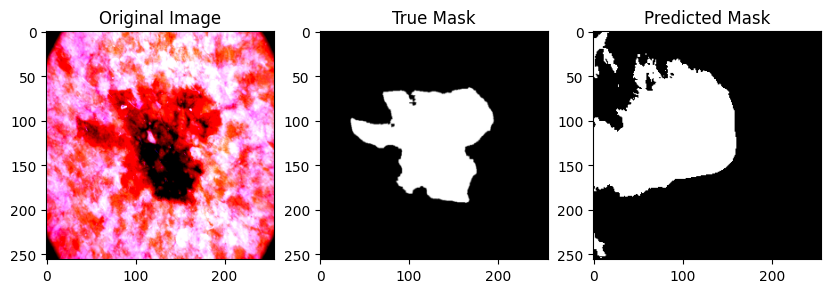

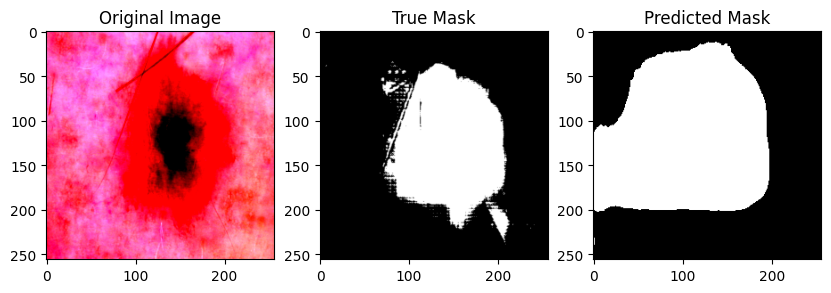

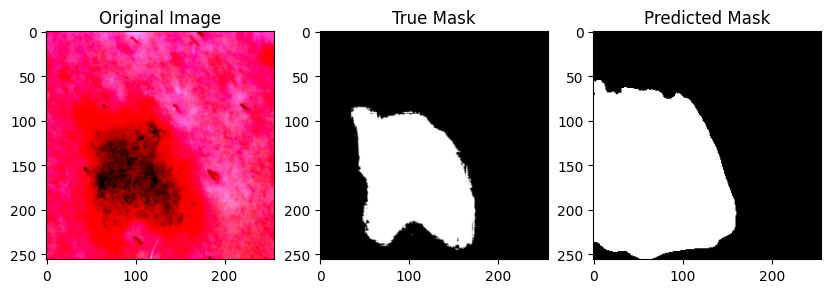

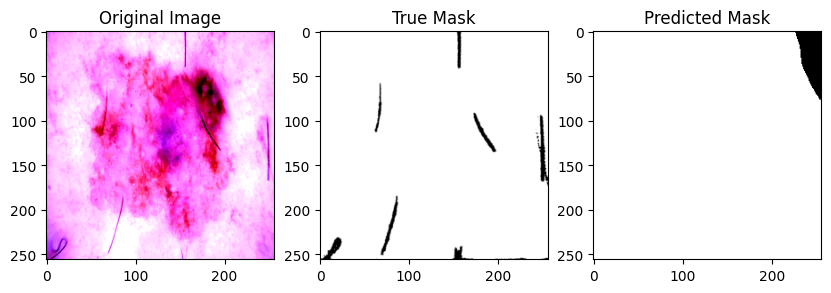

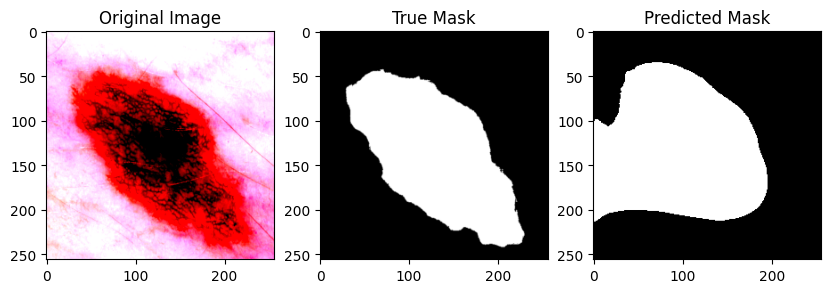

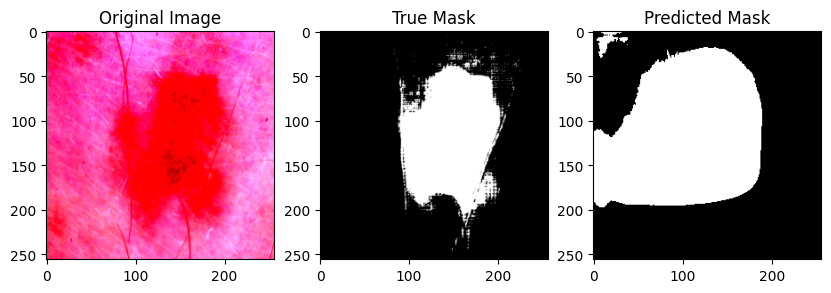

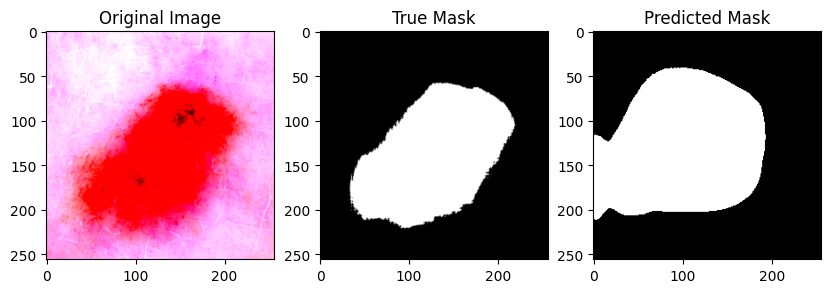

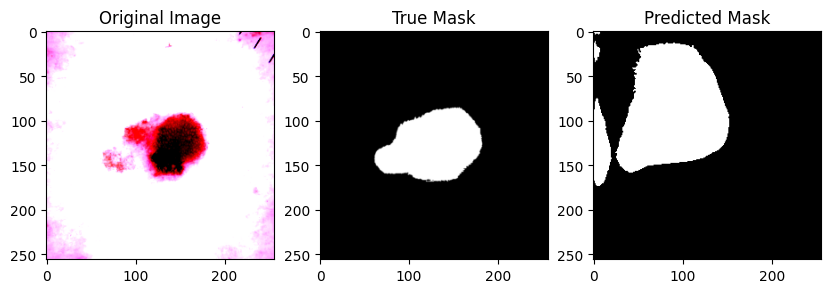

In [109]:
birefnet.eval()

with torch.no_grad():
    for images, masks in dataloader:
        images = images.to(device)
        outputs = birefnet(images)
        outputs_tensor = extract_first_tensor(outputs)
        if outputs_tensor is None:
            raise ValueError('Не удалось извлечь тензор из outputs')
        outputs_tensor = F.interpolate(outputs_tensor, size=masks.shape[-2:], mode='bilinear', align_corners=False)
        outputs_tensor = torch.sigmoid(outputs_tensor)
        outputs_tensor = (outputs_tensor > 0.5).float()

        images = images.cpu()
        masks = masks.cpu()
        outputs_tensor = outputs_tensor.cpu()

        for i in range(images.shape[0]):
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 3, 1)
            plt.title('Original Image')
            plt.imshow(images[i].permute(1, 2, 0).numpy())

            plt.subplot(1, 3, 2)
            plt.title('True Mask')
            plt.imshow(masks[i].squeeze().numpy(), cmap='gray')

            plt.subplot(1, 3, 3)
            plt.title('Predicted Mask')
            plt.imshow(outputs_tensor[i].squeeze().numpy(), cmap='gray')
            plt.show()


In [110]:
torch.save(birefnet.state_dict(), 'segmentation_birefnet_8testpic_23.02.25.pth')

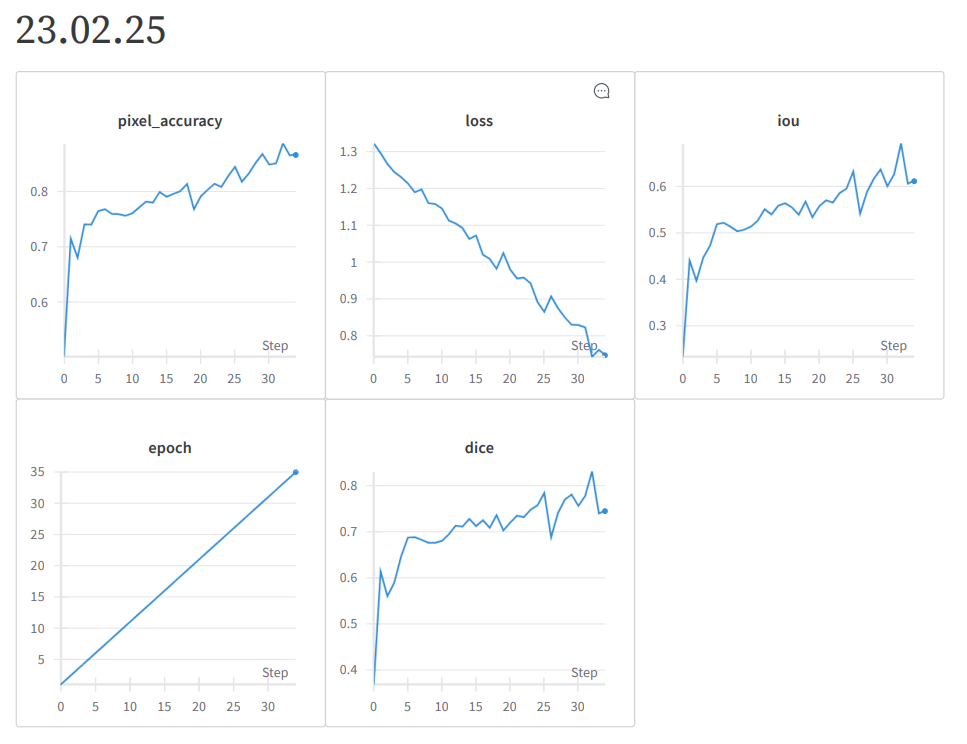

In [112]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: AuthenticAMD
cpu family	: 23
model		: 49
model name	: AMD EPYC 7B12
stepping	: 0
microcode	: 0xffffffff
cpu MHz		: 2249.998
cache size	: 512 KB
physical id	: 0
siblings	: 8
core id		: 0
cpu cores	: 4
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ht syscall nx mmxext fxsr_opt pdpe1gb rdtscp lm constant_tsc rep_good nopl nonstop_tsc cpuid extd_apicid tsc_known_freq pni pclmulqdq ssse3 fma cx16 sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm cmp_legacy cr8_legacy abm sse4a misalignsse 3dnowprefetch osvw topoext ssbd ibrs ibpb stibp vmmcall fsgsbase tsc_adjust bmi1 avx2 smep bmi2 rdseed adx smap clflushopt clwb sha_ni xsaveopt xsavec xgetbv1 clzero xsaveerptr arat npt nrip_save umip rdpid
bugs		: sysret_ss_attrs null_seg spectre_v1 spectre_v2 spec_store_bypass retbleed smt_rsb srso
bogo

In [113]:
!uname -a

Linux 8ce5b877a266 6.1.85+ #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024 x86_64 x86_64 x86_64 GNU/Linux


In [115]:
import torchvision
print('torch version:', torch.__version__)
print('torchvision version:', torchvision.__version__)

torch version: 2.5.1+cu124
torchvision version: 0.20.1+cu124
